# Spotify Recommendation System Project

**Purpose:** Build a scalable music recommendation system using PySpark and Spotify datasets.

**Group members:**

* Raakin Bhatti
* Aneesh Bulusu
* Walid Farhat
* Long Nguyen
* Strahinja Radakovic

# 1. Introduction and Motivation

**What is our big data problem? What is our goal?**
* Build a scalable music recommendation system using a large dataset of songs and their audio features from Spotify.
* Given the names of some songs, the algorithm will predict and recommend songs similar to the input songs based on their audio features (e.g. danceability, energy, acoustics, etc.) and categorical data like genres.
* Use Spark/PySpark to process large-scale data and develop machine learning algorithms.

**Why we chose building Recommendation Systems:**
* Recommendation systems are widely used in modern digital platforms to enhance user experience (e.g., Spotify, Netflix, Amazon).
* Help users discover relevant content, which helps to increase engagement and satisfaction.

**Why Spotify dataset?**
* Spotify is a leading music streaming platform which has rich data on songs, audio features, and artists.
* The dataset provides an opportunity to analyze music preferences and recommend personalized songs or playlists.

**What is a big data challenge?**
* Spotify data involves thousands of users, songs, and interactions, requiring storage and processing at scale.
* PySpark is well-suited for handling and analyzing big data with its distributed computing capabilities.

**Broader applications:**
* Insights from the project can extend to other recommendation systems.
* Demonstrates the integration of big data tools and machine learning for real-world applications.


**Filtering method:**

Our group's recommendation system will use Content-Based Filtering method instead of Collaborative filtering. Content-Based Filtering method analyzes the audio characteristics of songs you’ve previously enjoyed, then the model will make personalized suggestions. We do not use Collaborative filtering or user-based filtering method becuase we cannot collect the information related to Spotify's users such as `user_id`.

**What is the Target Variable for this project?**

In a content-based recommendation system, we do not have a traditional "target variable" like in supervised learning. Instead, the goal is to calculate similarity metrics between songs based on their features. However, you can think of the **song similarity score** (e.g., cosine similarity, Euclidean distance) as the implicit target metric for creating recommendations.

* The goal is to recommend songs similar to the input songs based on their audio features and genres.
* For our recommendation system, the focus is on matching songs based on audio features like danceability, energy, acousticness, etc., and categorical data like genre.

**What are the interesting Features of the dataset?**

*Numerical Features (Audio Characteristics):* 

* danceability: Indicates how suitable a track is for dancing.
* energy: Represents the intensity and activity level of a track.
* loudness: Measures the decibel level of the track.
* acousticness: Likelihood of the track being acoustic.
* instrumentalness: Determines the degree to which a track is instrumental.
* valence: Describes the musical positiveness conveyed by a track.
* tempo: The speed of the song in beats per minute (BPM).
* duration_ms: Song duration, which can help differentiate between shorter and longer tracks.

*Categorical Features:*

* genre: A key factor in identifying similar songs. 
* key: Musical key in which the song is composed.
* mode: Indicates whether the song is in a major or minor scale.

*Meta Information (Optional):*

* popularity: While not directly linked to audio characteristics, it can serve as a secondary ranking factor in your recommendations.
* year: Could help in filtering songs by era if needed.

## Setting up Spark

This section is optional. In case that you have not installed Spark, Hadoop, etc. in your local machine, then this part will help setting up Spark in the Jupyter Notebook for running.

In [1]:
## OPTIONAL: Setting up Spark in Jupyter Notebook

# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
# !tar -xvf spark-3.5.3-bin-hadoop3.tgz
# !pip install findspark
# 
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"
# 
# import findspark
# findspark.init()
# findspark.find()

In [2]:
## OPTIONAL: Test if PySpark is ready to go

# from pyspark.sql import SparkSession
# 
# spark = SparkSession.builder.appName("Test").getOrCreate()
# print(f"Spark version:", spark.version)
# 
# spark.stop()

## expected result: 3.5.3 or similar

# 2. Data Collection

**Required Tasks:**
* Load the dataset into a PySpark DataFrame.
* Verify the dataset schema and check if the data is loaded correctly.

**Output:** A PySpark DataFrame loaded and ready for processing, with the schema verified.


### How we get the dataset?

We extracted the dataset from Spotify using Spotify API and the `Spotipy` library in Python.

Attached the Python files for extraction and transformation (from JSON to CSV). Please note that these files are for references only, because in order to run those files, you will have to set up a virtual environment.

### Loading datasets

In [3]:
import findspark
findspark.init()
findspark.find()

'C:\\Program Files\\spark-3.5.3'

In [4]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, lit
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

In [5]:
# initialize a SparkSession
spark = SparkSession.builder \
    .appName("SpotifyRecommendationSystem") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

print(f"Spark version:", spark.version)

Spark version: 3.5.3


In [6]:
# load dataset into a DataFrame
file_path = "./dataset/spotify_dataset.csv" # Note: The dataset file is too large (>250 MB) to commit to a GitHub repo.
spotify_df = spark.read.csv(file_path, header=True, inferSchema=True)

# display the first few rows
spotify_df.show(5)


+---+-------------+----------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|_c0|  artist_name|      track_name|            track_id|popularity|year|   genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|
+---+-------------+----------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|  0|   Jason Mraz| I Won't Give Up|53QF56cjZA9RTuuMZ...|        68|2012|acoustic|       0.483| 0.303|  4| -10.058|   1|     0.0429|       0.694|             0.0|   0.115|  0.139|133.406|   240166.0|           3.0|
|  1|   Jason Mraz|93 Million Miles|1s8tP3jP4GZcyHDsj...|        50|2012|acoustic|       0.572| 0.454|  3| -10.286|   1|     0.0258|       0

# 3. Data Inspection and Validation

In this section, we will do the following tasks:

* Check the data schema with column names and data types.
* Convert data types if needed.
* Check for the summary statistics of the dataset.
* Check for missing values. Handle missing values properly.

In [7]:
# print schema to verify column names and data types
spotify_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- time_signature: double (nullable = true)



**Data type conversins:**

From [Spotify's API documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) about track's audio features, each feature has its own meaning and data types. So we will convert the data types of features in our dataset to match Spotify's documentation.

In [8]:
# casting columns to their appropriate data types as per Spotify's documentation
spotify_df = spotify_df \
    .withColumn("popularity", col("popularity").cast("int")) \
    .withColumn("year", col("year").cast("int")) \
    .withColumn("danceability", col("danceability").cast("float")) \
    .withColumn("energy", col("energy").cast("float")) \
    .withColumn("key", col("key").cast("int")) \
    .withColumn("loudness", col("loudness").cast("float")) \
    .withColumn("mode", col("mode").cast("int")) \
    .withColumn("speechiness", col("speechiness").cast("float")) \
    .withColumn("acousticness", col("acousticness").cast("float")) \
    .withColumn("instrumentalness", col("instrumentalness").cast("float")) \
    .withColumn("liveness", col("liveness").cast("float")) \
    .withColumn("tempo", col("tempo").cast("float")) \
    .withColumn("time_signature", col("time_signature").cast("int"))

# re-check the updated schema
spotify_df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- time_signature: integer (nullable = true)



In [9]:
# count total rows in the dataset
total_rows = spotify_df.count()
print(f"Total rows in the dataset: {total_rows}")

Total rows in the dataset: 1159764


Remarks: The dataset contains 1,159,764 rows, which is quite large, indicating the need for big data tools like PySpark.

**Check for Summary Statistics:**

Next, we want to check for the summary statistics of the dataset. In [Spark](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.describe.html), if using `.describe()` method, it will by default calculate the stats for all columns including both numerical and non-numerical (string) columns. Therefore, we have to filter out the columns based on their data types as follows.

In [10]:
# filter numeric columns using dtypes
numeric_columns = [name for name, dtype in spotify_df.dtypes if dtype in ('int', 'bigint', 'double', 'float', 'decimal')]

# select only numeric columns
numeric_df = spotify_df.select(*numeric_columns)

# show summary statistics for numerical columns only
numeric_df.describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+
|summary|              _c0|        popularity|              year|     danceability|            energy|               key|          loudness|             mode|        speechiness|       acousticness|   instrumentalness|           liveness|            valence|             tempo|       duration_ms|    time_signature|
+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+
|  count|          1159764|           1158091|      

**Remarks for summary statistics:**

* `popularity`: Ranges from 0 to 100, indicating a reasonable scale for popularity.
* `year`: The dataset includes tracks from 0 to 2023. The value 0 seems anomalous and might need further investigation.
* Other features like `danceability`, `energy`, `tempo`, and `duration_ms` have a wide range of values, which may need normalization or standardization for machine learning.
* Potential outliers: Columns like `tempo` (min = -24.073) and `loudness` (min = -58.1) have unusual values that might indicate outliers or data entry issues.

In [11]:
# check for missing values in each column
missing_values = spotify_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in spotify_df.columns
])
missing_values.show()

+---+-----------+----------+--------+----------+----+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+
|_c0|artist_name|track_name|track_id|popularity|year|genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|
+---+-----------+----------+--------+----------+----+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+
|  0|          0|         0|       0|      1673| 623|    0|        1184|   408|162|      94|  33|         16|           8|               3|       2|      0|    0|          0|             0|
+---+-----------+----------+--------+----------+----+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+



**Remarks for missing values:**

* Columns with missing data: `popularity` (1,673 missing values), `year` (623), and others such as  `danceability`, `energy`, `key`, `loudness`, and `mode`.
* Given the dataset has over 1.15M rows, the proportion of missing data is extremely small (less than 0.1% for all affected columns).
* In this case, we will drop rows with missing values in features that are critical for our recommendation system.

In [12]:
# drop rows with missing data in critical columns
columns_to_check = ['popularity', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']

spotify_df_clean = spotify_df.na.drop(subset=columns_to_check)

# verify the number of rows after dropping
cleaned_rows = spotify_df_clean.count()
print(f"Rows after dropping missing data: {cleaned_rows}")

dropped_rows = total_rows - cleaned_rows
print(f"Number of rows dropped: {dropped_rows}")


Rows after dropping missing data: 1158091
Number of rows dropped: 1673


# 4. Data Filtering

In this section, we will identify and retain only the relevant features for building the recommendation system. We will consider dropping irrelevant or redundant columns like `_c0` that may not contribute to the model.

* Since `time_signature` feature has more than 13K values of anamolies and has little importance to finding similarities between songs, we will drop this feature.
* `_c0` feature is only the index of the dataset and will contribute to the model so we will drop it.

In [13]:
# retain only relevant features for the recommendation system
selected_columns = [
    'artist_name', 'track_name', 'track_id', 'popularity', 'year', 
    'genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 
    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo', 'duration_ms'
]

# create a filtered DataFrame
spotify_df_filtered = spotify_df_clean.select(*selected_columns)

# show the schema of the filtered DataFrame
spotify_df_filtered.printSchema()

# verify the filtering process
spotify_df_filtered.show(5)


root
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: double (nullable = true)

+-------------+----------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|  artist_name|      track_name|            track_id|popularity|year|   gen

In [14]:
# Count distinct values in key columns
key_columns = ['artist_name', 'track_name', 'genre']
distinct_counts = {col_name: spotify_df_filtered.select(col_name).distinct().count() for col_name in key_columns}

for col_name, count in distinct_counts.items():
    print(f"Distinct values in {col_name}: {count}")

Distinct values in artist_name: 64144
Distinct values in track_name: 880697
Distinct values in genre: 82


# 5. Data Transformations

Here are the goals of this section:

1. **Encode categorical features:** Features like `artist_name` are categorical and need to be encoded to numeric values for modeling.
2. **Normalize or scale numeric features:** Standardized scales are crucial for similarity metrics like cosine similarity or Euclidean distance. Features like `danceability`, `energy`, `tempo`, etc., may have varying ranges, which can affect model performance. Therefore, we will normalize or standardize these values.
3. **Generate additional features (if needed):** Create new features based on existing ones. For example, you might engineer a feature for "popularity bucket" if grouping songs by popularity levels makes sense for your recommendation algorithm. Or group songs by year into broader time periods (e.g., 5-year period) for optional temporal filtering.

## 5.1. Encoding categorial features

There are mutilple approaches for encoding categorical features, such as one-hot encoding, label encoding, embedding, frequency/popularity encoding, etc. We will choose the most suitable approach for each categorical feature based on their characteristics in the dataset.

We will encode `artist_name` to numeric values using PySpark's `StringIndexer`.

Note that we will not use one-hot encoding for `genre` feature but we will use TF-IDF vectorization in the later steps. See more below.

In [15]:
# Get distinct values of the 'genre' column
unique_genres = spotify_df_filtered.select("genre").distinct()
unique_genres_list = [row['genre'] for row in unique_genres.collect()]
print(unique_genres_list)

['singer-songwriter', 'folk', 'hardstyle', 'pop', 'death-metal', 'detroit-techno', 'k-pop', 'ambient', 'guitar', 'goth', 'cantopop', 'blues', 'breakbeat', 'dance', 'groove', 'indian', 'german', 'sad', 'spanish', 'french', 'electronic', 'dub', 'deep-house', 'edm', 'rock-n-roll', 'power-pop', 'progressive-house', 'swedish', 'chill', 'party', 'hip-hop', 'techno', 'hard-rock', 'indie-pop', 'jazz', 'new-age', 'show-tunes', 'trip-hop', 'punk-rock', 'country', 'hardcore', 'industrial', 'metalcore', 'songwriter', 'metal', 'soul', 'psych-rock', 'grindcore', 'pop-film', 'salsa', 'dancehall', 'club', 'electro', 'samba', 'drum-and-bass', 'heavy-metal', 'house', 'chicago-house', 'funk', 'alt-rock', 'sleep', 'dubstep', 'gospel', 'acoustic', 'rock', 'ska', 'opera', 'black-metal', 'romance', 'emo', 'tango', 'punk', 'disco', 'classical', 'sertanejo', 'afrobeat', 'garage', 'forro', 'trance', 'minimal-techno', 'comedy', 'piano']


### Encoding `artist_name` feature

We will use the Frequency (or Popularity) Encoding technique because `artist_name` has a high cardinality (64,159 distinct values). ALso, frequency encoding reduces the feature space while retaining meaningful patterns (e.g., more popular artists might appear in recommendations more frequently).

In [19]:
# Calculate the frequency of each artist
artist_frequency = spotify_df_filtered.groupBy("artist_name").count() \
                             .withColumnRenamed("count", "artist_frequency")

# Join the frequency data back to the main DataFrame
spotify_df_encoded = spotify_df_filtered.join(artist_frequency, on="artist_name", how="left")

# Show the results
spotify_df_encoded.select("artist_name", "artist_frequency").distinct().show(5, truncate=False)

+-----------------+----------------+
|artist_name      |artist_frequency|
+-----------------+----------------+
|Ramshackle Glory |31              |
|Zach Berkman     |17              |
|The Black Keys   |209             |
|Black Pistol Fire|77              |
|Jane's Addiction |55              |
+-----------------+----------------+
only showing top 5 rows



In [20]:
# # from pyspark.sql.functions import col, count, lit
# 
# # Calculate the frequency of each artist
# artist_frequency = spotify_df_encoded.groupBy("artist_name").count() \
#                              .withColumnRenamed("count", "artist_frequency")
# 
# # Join the frequency data back to the main DataFrame
# spotify_df_encoded = spotify_df_encoded.join(artist_frequency, on="artist_name", how="left")
# 
# # Show the results
# spotify_df_encoded.select("artist_name", "artist_frequency").distinct().show(5, truncate=False)


*Note:* The frequencies (31, 17, etc.) reflect the occurrence count of each artist in the dataset, which is intuitive and interpretable.

In [21]:
# review the dataframe
# note that there are one new columns: artist_frequency

spotify_df_encoded.show(5)

+-------------+----------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+----------------+
|  artist_name|      track_name|            track_id|popularity|year|   genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|artist_frequency|
+-------------+----------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+----------------+
|   Jason Mraz| I Won't Give Up|53QF56cjZA9RTuuMZ...|        68|2012|acoustic|       0.483| 0.303|  4| -10.058|   1|     0.0429|       0.694|             0.0|   0.115|  0.139|133.406|   240166.0|             193|
|   Jason Mraz|93 Million Miles|1s8tP3jP4GZcyHDsj...|        50|2012|acoustic|       0.572| 0.454|  3| -10.286|   1|     0.0258|       0.477|       

## 5.2. Normalize Numerical Features

We will normalize numerical features like `danceability`, `energy`, `tempo`, etc., to have values between 0 and 1 using `MinMaxScaler`. 

Min-Max scaling is typically the best choice for recommendation systems, especially when working with similarity metrics like cosine similarity or Euclidean distance.

There are a few reasons why we should do scaling for these numerical values:

* Scaling helps to standardize different scales across features. For example, features like `loudness` (negative values) and `tempo` (positive, larger range) have much different scales.
* Scaling also improves model performance because many ML algorithms, such as neural networks and matrix factorization (used in recommendation systems), will converge faster and perform better with normalized input data.

In [22]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

# define numerical features to normalize
numerical_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 
    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo', 'duration_ms', 'popularity'
]

# assemble numerical features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="numerical_vector")
spotify_df_vectorized = assembler.transform(spotify_df_encoded)

# apply Min-Max Scaler
scaler = MinMaxScaler(inputCol="numerical_vector", outputCol="scaled_features")
scaler_model = scaler.fit(spotify_df_vectorized)
spotify_df_normalized = scaler_model.transform(spotify_df_vectorized)

# extract scaled features into separate columns
def extract_column(index):
    """UDF to extract specific column from dense vector."""
    return udf(lambda vector: float(vector[index]), returnType=DoubleType())

# loop through features and create new columns for each scaled feature
for i, feature in enumerate(numerical_features):
    spotify_df_normalized = spotify_df_normalized.withColumn(f"{feature}_scaled", extract_column(i)(col("scaled_features")))

# drop original and intermediate columns
columns_to_drop = numerical_features + ["numerical_vector", "scaled_features"]
spotify_df_normalized = spotify_df_normalized.drop(*columns_to_drop)

# show the scaled features
spotify_df_normalized.select(*[f"{feature}_scaled" for feature in numerical_features]).show(5, truncate=False)


+-------------------+-------------------+-------------------+------------------+-----------+--------------------+-------------------+-----------------------+-------------------+--------------+------------------+--------------------+------------------+
|danceability_scaled|energy_scaled      |key_scaled         |loudness_scaled   |mode_scaled|speechiness_scaled  |acousticness_scaled|instrumentalness_scaled|liveness_scaled    |valence_scaled|tempo_scaled      |duration_ms_scaled  |popularity_scaled |
+-------------------+-------------------+-------------------+------------------+-----------+--------------------+-------------------+-----------------------+-------------------+--------------+------------------+--------------------+------------------+
|0.4864048584089521 |0.30300000309944153|0.36363636363636365|0.747479463142717 |1.0        |0.044181255481279255|0.6967871600104057 |0.0                    |0.11500000208616257|0.139         |0.5336389734062985|0.03969260582199785 |0.68        

*Note:* The values in new columns (e.g. `energy_scaled`) are normalized to be between 0 and 1.

In [23]:
# review the dataframe
spotify_df_normalized.show(5)

+----------------+--------------------+--------------------+----+--------+----------------+-------------------+-------------------+------------------+------------------+-----------+-------------------+--------------------+-----------------------+-------------------+--------------+-------------------+--------------------+-----------------+
|     artist_name|          track_name|            track_id|year|   genre|artist_frequency|danceability_scaled|      energy_scaled|        key_scaled|   loudness_scaled|mode_scaled| speechiness_scaled| acousticness_scaled|instrumentalness_scaled|    liveness_scaled|valence_scaled|       tempo_scaled|  duration_ms_scaled|popularity_scaled|
+----------------+--------------------+--------------------+----+--------+----------------+-------------------+-------------------+------------------+------------------+-----------+-------------------+--------------------+-----------------------+-------------------+--------------+-------------------+-----------------

## 5.3. Group time periods (bucketing)

We want to group the years because bucketing years into ranges helps identify patterns or trends in specific time periods.

In [24]:
from pyspark.ml.feature import Bucketizer

# define time period splits and labels
splits = [1999, 2004, 2009, 2014, 2019, 2024]
bucket_labels = ["2000-2004", "2005-2009", "2010-2014", "2015-2019", "2020-2023"]

# add a new column for bucket indexes
bucketizer = Bucketizer(
    splits=splits, 
    inputCol="year", 
    outputCol="year_bucket"
)
spotify_df_bucket = bucketizer.transform(spotify_df_normalized)

# map bucket indices to labels
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# create a UDF to map bucket indices to bucket labels
bucket_label_udf = udf(lambda idx: bucket_labels[int(idx)], StringType())
spotify_df_bucket = spotify_df_bucket.withColumn("year_period", bucket_label_udf(col("year_bucket")))

# drop intermediate column (year_bucket) if no longer needed
spotify_df_bucket = spotify_df_bucket.drop("year_bucket")

# show results
spotify_df_bucket.select("track_name", "year", "year_period").show(10)


+--------------------+----+-----------+
|          track_name|year|year_period|
+--------------------+----+-----------+
|     I Won't Give Up|2012|  2010-2014|
|    93 Million Miles|2012|  2010-2014|
|    Do Not Let Me Go|2012|  2010-2014|
|            Fast Car|2012|  2010-2014|
|    Sky's Still Blue|2012|  2010-2014|
|       What They Say|2012|  2010-2014|
|Walking in a Wint...|2012|  2010-2014|
|       Dancing Shoes|2012|  2010-2014|
|Living in the Moment|2012|  2010-2014|
|              Heaven|2012|  2010-2014|
+--------------------+----+-----------+
only showing top 10 rows



In [26]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# StringIndexer: Convert year_period into numerical indices
period_indexer = StringIndexer(inputCol="year_period", outputCol="year_period_index")
spotify_df_bucket = period_indexer.fit(spotify_df_bucket).transform(spotify_df_bucket)

# OneHotEncoder: Convert indices into one-hot encoded vectors
period_encoder = OneHotEncoder(inputCol="year_period_index", outputCol="year_period_onehot", dropLast=False)
spotify_df_bucket = period_encoder.fit(spotify_df_bucket).transform(spotify_df_bucket)

# Show the results
spotify_df_bucket.select("track_name", "year", "year_period", "year_period_index", "year_period_onehot").show(10, truncate=False)


+------------------------------+----+-----------+-----------------+------------------+
|track_name                    |year|year_period|year_period_index|year_period_onehot|
+------------------------------+----+-----------+-----------------+------------------+
|I Won't Give Up               |2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|93 Million Miles              |2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|Do Not Let Me Go              |2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|Fast Car                      |2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|Sky's Still Blue              |2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|What They Say                 |2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|Walking in a Winter Wonderland|2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|Dancing Shoes                 |2012|2010-2014  |2.0              |(5,[2],[1.0])     |
|Living in the Moment          |2012|2010-2

*Note:* For the `year_period_onehot` column, the `(5, [2], [1.0])` format indicates a sparse one-hot encoded vector with 5 possible time periods (buckets), where the index `2` corresponds to the time period `2010-2014`.

In [27]:
# rename the finalized dataframe before moving on to EDA
spotify_df_final = spotify_df_bucket

In [28]:
spotify_df_final.show(5)

+----------------+--------------------+--------------------+----+--------+----------------+-------------------+-------------------+------------------+------------------+-----------+-------------------+--------------------+-----------------------+-------------------+--------------+-------------------+--------------------+-----------------+-----------+-----------------+------------------+
|     artist_name|          track_name|            track_id|year|   genre|artist_frequency|danceability_scaled|      energy_scaled|        key_scaled|   loudness_scaled|mode_scaled| speechiness_scaled| acousticness_scaled|instrumentalness_scaled|    liveness_scaled|valence_scaled|       tempo_scaled|  duration_ms_scaled|popularity_scaled|year_period|year_period_index|year_period_onehot|
+----------------+--------------------+--------------------+----+--------+----------------+-------------------+-------------------+------------------+------------------+-----------+-------------------+-------------------

In [29]:
# print schema to verify data types
spotify_df_final.printSchema()


root
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- artist_frequency: long (nullable = true)
 |-- danceability_scaled: double (nullable = true)
 |-- energy_scaled: double (nullable = true)
 |-- key_scaled: double (nullable = true)
 |-- loudness_scaled: double (nullable = true)
 |-- mode_scaled: double (nullable = true)
 |-- speechiness_scaled: double (nullable = true)
 |-- acousticness_scaled: double (nullable = true)
 |-- instrumentalness_scaled: double (nullable = true)
 |-- liveness_scaled: double (nullable = true)
 |-- valence_scaled: double (nullable = true)
 |-- tempo_scaled: double (nullable = true)
 |-- duration_ms_scaled: double (nullable = true)
 |-- popularity_scaled: double (nullable = true)
 |-- year_period: string (nullable = true)
 |-- year_period_index: double (nullable = false)
 |-- year_period_onehot: vector (null

*Note:* Reviewing the schema of the finalized dataframe:
* One-hot encoded features (`genre_onehot`, `year_period_onehot`) are represented as `vectors`. This `vector` type is suitable for recommendation systems and similarity algorithms.
* Scaled numerical features (`*_scaled`) are of `double` type, ensuring compatibility with analysis and modeling tasks.

# 6. Exploratroy Data Analysis (EDA)

* The overall distribution of genres.
* Trends of genre popularity over time.

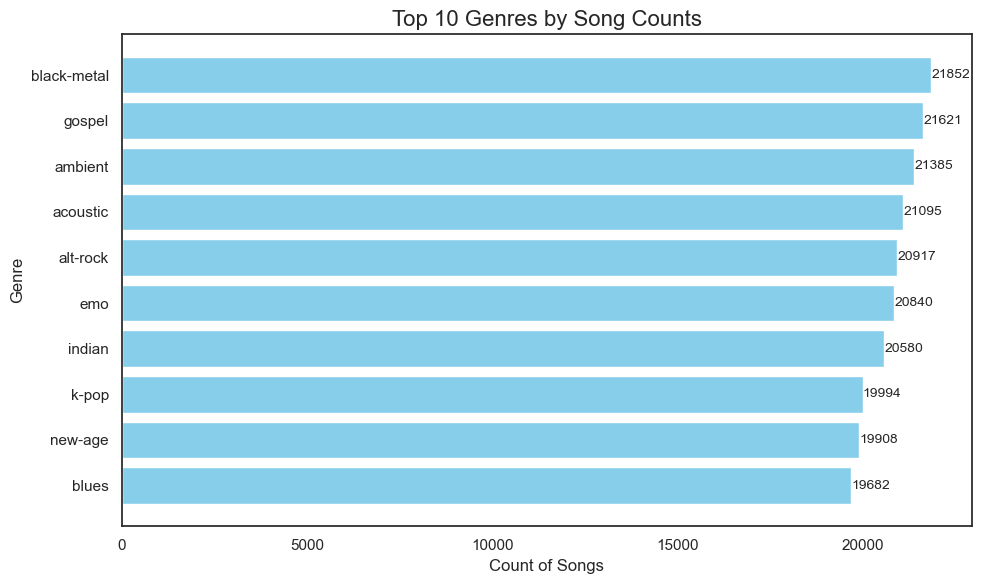

In [28]:
# Genre Distribution chart
# This chart now includes an option to show either the top 10 genres or all genres.

# aggregate to count songs per genre
genre_distribution = spotify_df_final.groupBy("genre").count().orderBy("count", ascending=False)

# convert to Pandas for visualization
genre_distribution_pd = genre_distribution.toPandas()

# Option 1: Show top 10 genres - Uncomment to switch to this option
genre_distribution_pd_to_plot = genre_distribution_pd.head(10)

# Option 2: Show all genres - Uncomment to switch to this option
# genre_distribution_pd_to_plot = genre_distribution_pd

# plot
plt.figure(figsize=(10, 6))
bars = plt.barh(genre_distribution_pd_to_plot['genre'], genre_distribution_pd_to_plot['count'], color='skyblue')
plt.title('Top 10 Genres by Song Counts', fontsize=16)
plt.xlabel('Count of Songs', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.gca().invert_yaxis()

# add values at the end of the bars
for bar in bars:
    plt.text(
        bar.get_width() + 10,
        bar.get_y() + bar.get_height() / 2,
        str(int(bar.get_width())),
        va='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()


*Note:*

* This chart visualizes the distribution of the most common genres in the dataset.
* Genres like black-metal, gospel, and ambient dominate the dataset, with more than 20,000 songs each.
* This chart helps us understand the diversity in the dataset and the potential need for balancing genres in recommendations.

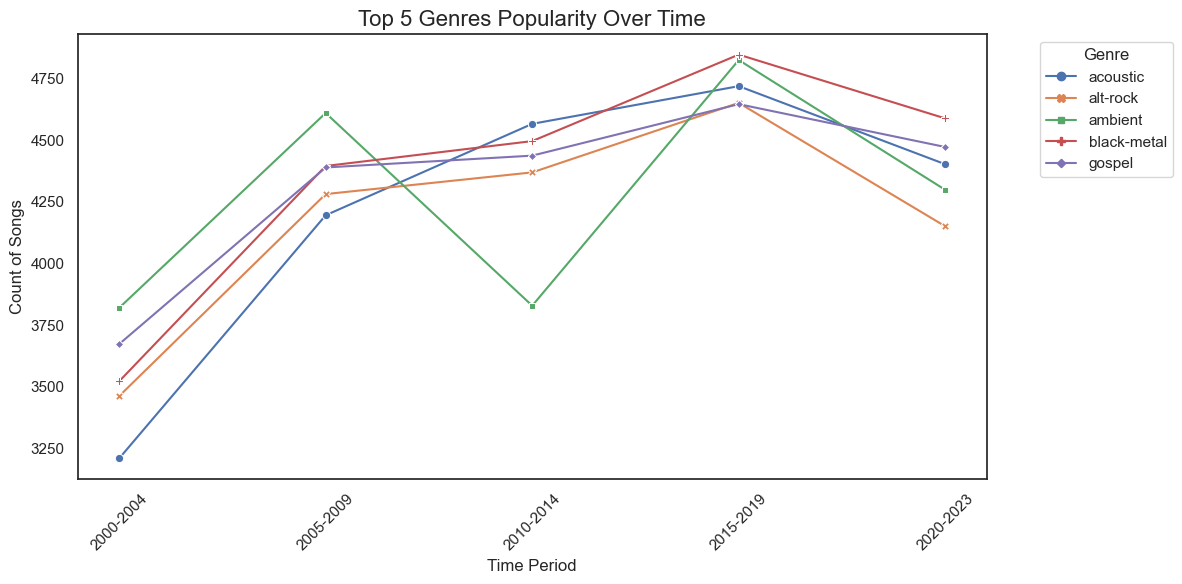

In [29]:
# Top 5 Genres over time

# aggregate to count songs per genre and time period
genre_trends = (
    spotify_df_final.groupBy("year_period", "genre")
    .count()
    .orderBy("year_period", "count", ascending=[True, False])
)

# convert to Pandas for visualization
genre_trends_pd = genre_trends.toPandas()

# aggregate top 5 genres by total count
top_5_genres = (
    genre_trends_pd.groupby("genre")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# filter the trends for the top 5 genres
genre_trends_pd_top5 = genre_trends_pd[genre_trends_pd["genre"].isin(top_5_genres)]

# create a pivot table for plotting
genre_trends_pivot = genre_trends_pd_top5.pivot(index="year_period", columns="genre", values="count").fillna(0)

# plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=genre_trends_pivot, markers=True, dashes=False)

plt.title('Top 5 Genres Popularity Over Time', fontsize=16)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Count of Songs', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
# Top Artists for Top Genres
# Top 5 Songs by Popularity for Top Genres

TOP_LIMIT = 2

# Get top genres by song count
top_genres = spotify_df_final.groupBy("genre").count().orderBy("count", ascending=False).limit(TOP_LIMIT).toPandas()

for genre in top_genres['genre']:
    # Top artists for each top genre
    print(f"Genre: {genre}")
    top_artists = (
        spotify_df_final.filter(spotify_df_final["genre"] == genre)
        .groupBy("artist_name")
        .count()
        .orderBy("count", ascending=False)
        .limit(TOP_LIMIT)
        .toPandas()
    )
    print(f"Top {TOP_LIMIT} Artists by Song Counts for Genre: {genre}")
    print(top_artists)

    # Top songs by popularity for each genre
    top_songs = (
        spotify_df_final.filter(spotify_df_final["genre"] == genre)
        .orderBy("popularity_scaled", ascending=False)
        .select("track_name", "artist_name", "popularity_scaled")
        .limit(TOP_LIMIT)
        .toPandas()
    )
    print(f"Top {TOP_LIMIT} Songs by Popularity for Genre: {genre}")
    print(top_songs)
    print()


Genre: black-metal
Top 2 Artists by Song Counts for Genre: black-metal
       artist_name  count
0  Cradle Of Filth    247
1         Behemoth    188
Top 2 Songs by Popularity for Genre: black-metal
   track_name       artist_name  popularity_scaled
0  Doomswitch  Make Them Suffer               0.58
1    Step One  Make Them Suffer               0.55

Genre: gospel
Top 2 Artists by Song Counts for Genre: gospel
          artist_name  count
0  Gaither Vocal Band    230
1  Israel & New Breed    209
Top 2 Songs by Popularity for Genre: gospel
            track_name     artist_name  popularity_scaled
0    Deserto (Ao Vivo)    Maria Marçal               0.73
1  Me Atraiu - Ao Vivo  Gabriela Rocha               0.71



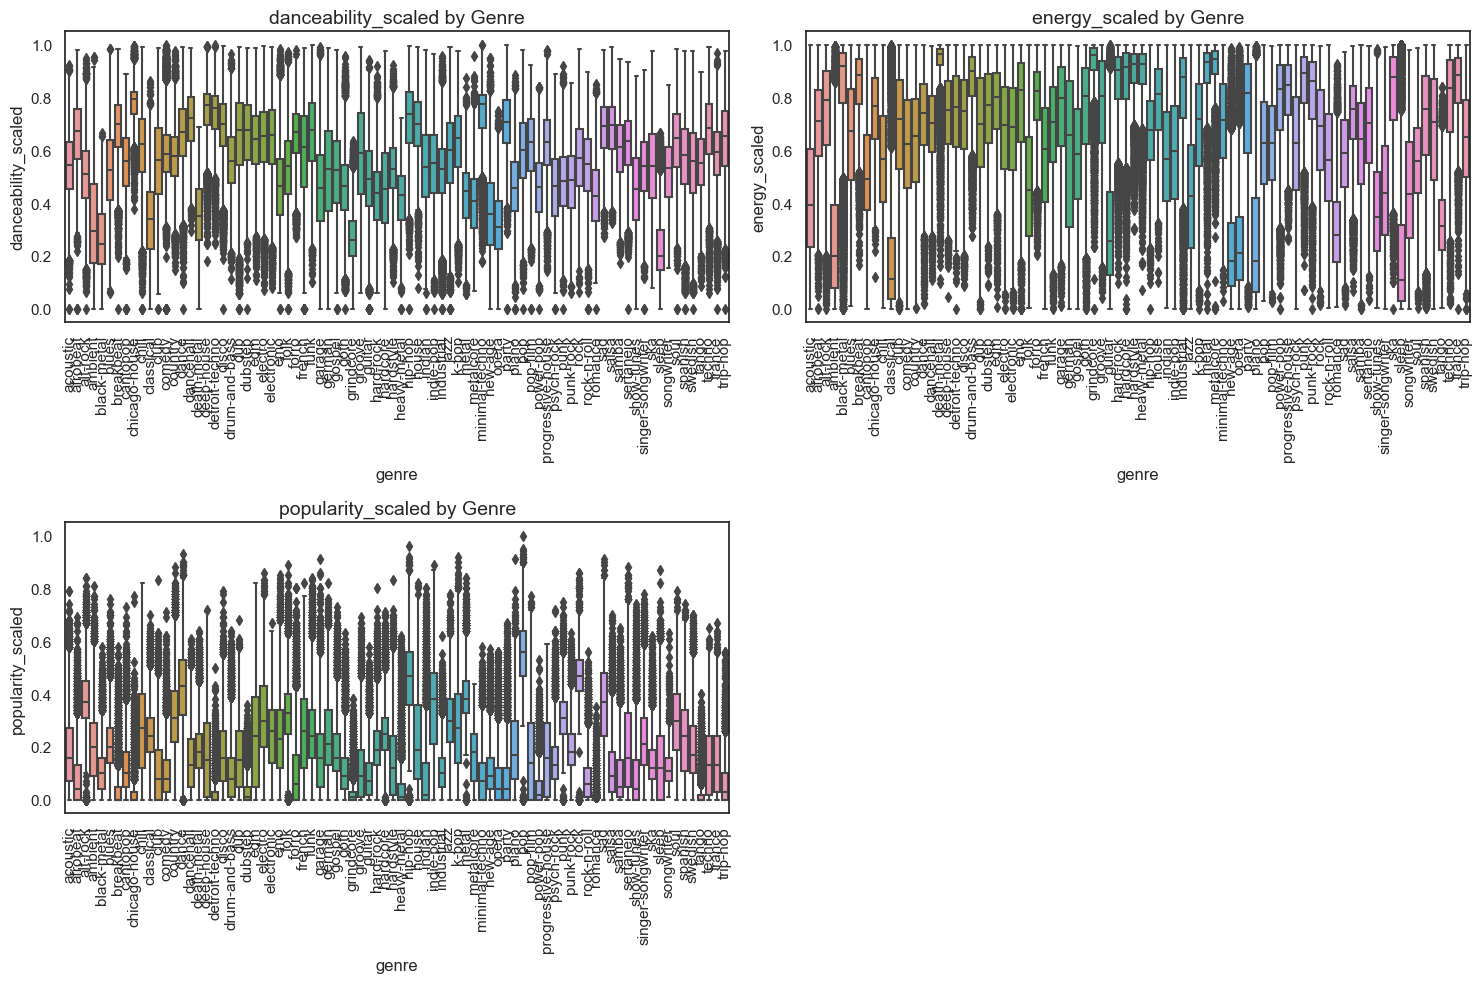

In [31]:
# Correlation of genre_onehot with Numerical Features
# Purpose: Examine how genres relate to numerical features like danceability, energy, or popularity.

# convert PySpark DataFrame to Pandas for visualization
numerical_features = ['danceability_scaled', 'energy_scaled', 'popularity_scaled']
features_with_genre = spotify_df_final.select("genre", *numerical_features).toPandas()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='genre', y=feature, data=features_with_genre)
    plt.title(f'{feature} by Genre', fontsize=14)
    plt.xticks(rotation=90)
    plt.ylabel(feature, fontsize=12)
plt.tight_layout()
plt.show()


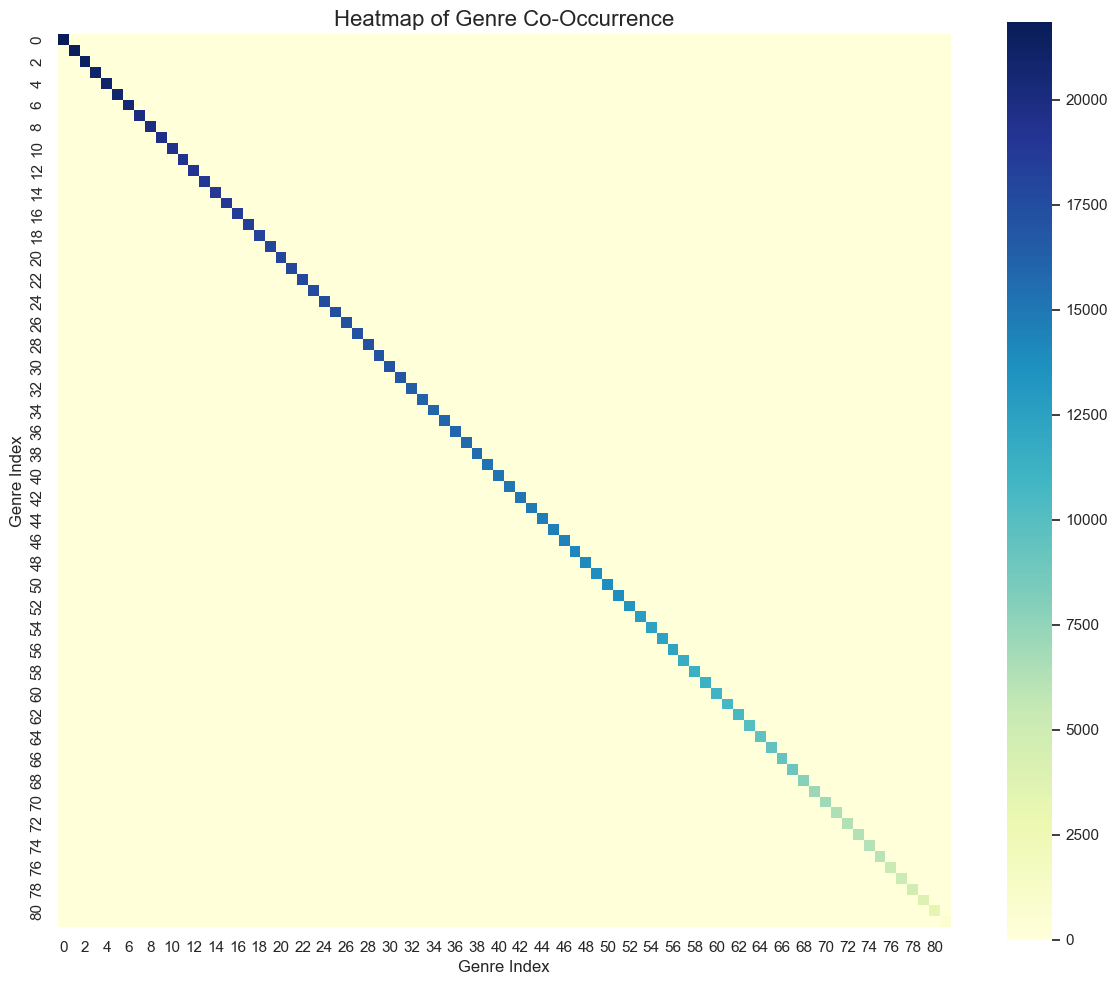

In [32]:
# Heatmap of Genre Correlations
# Purpose: Explore how genres are distributed relative to other one-hot encoded genres.

# Extract genre_onehot and convert to Pandas
genre_onehot_pd = spotify_df_final.select("genre_onehot").toPandas()

# Convert sparse vectors to dense arrays
import numpy as np
from scipy.sparse import csr_matrix

dense_onehot = np.array(genre_onehot_pd["genre_onehot"].apply(lambda x: x.toArray()).tolist())
co_occurrence = csr_matrix(dense_onehot).T.dot(csr_matrix(dense_onehot)).toarray()

# Plot heatmap
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap="YlGnBu", square=True, cbar=True)
plt.title("Heatmap of Genre Co-Occurrence", fontsize=16)
plt.xlabel("Genre Index", fontsize=12)
plt.ylabel("Genre Index", fontsize=12)
plt.tight_layout()
plt.show()


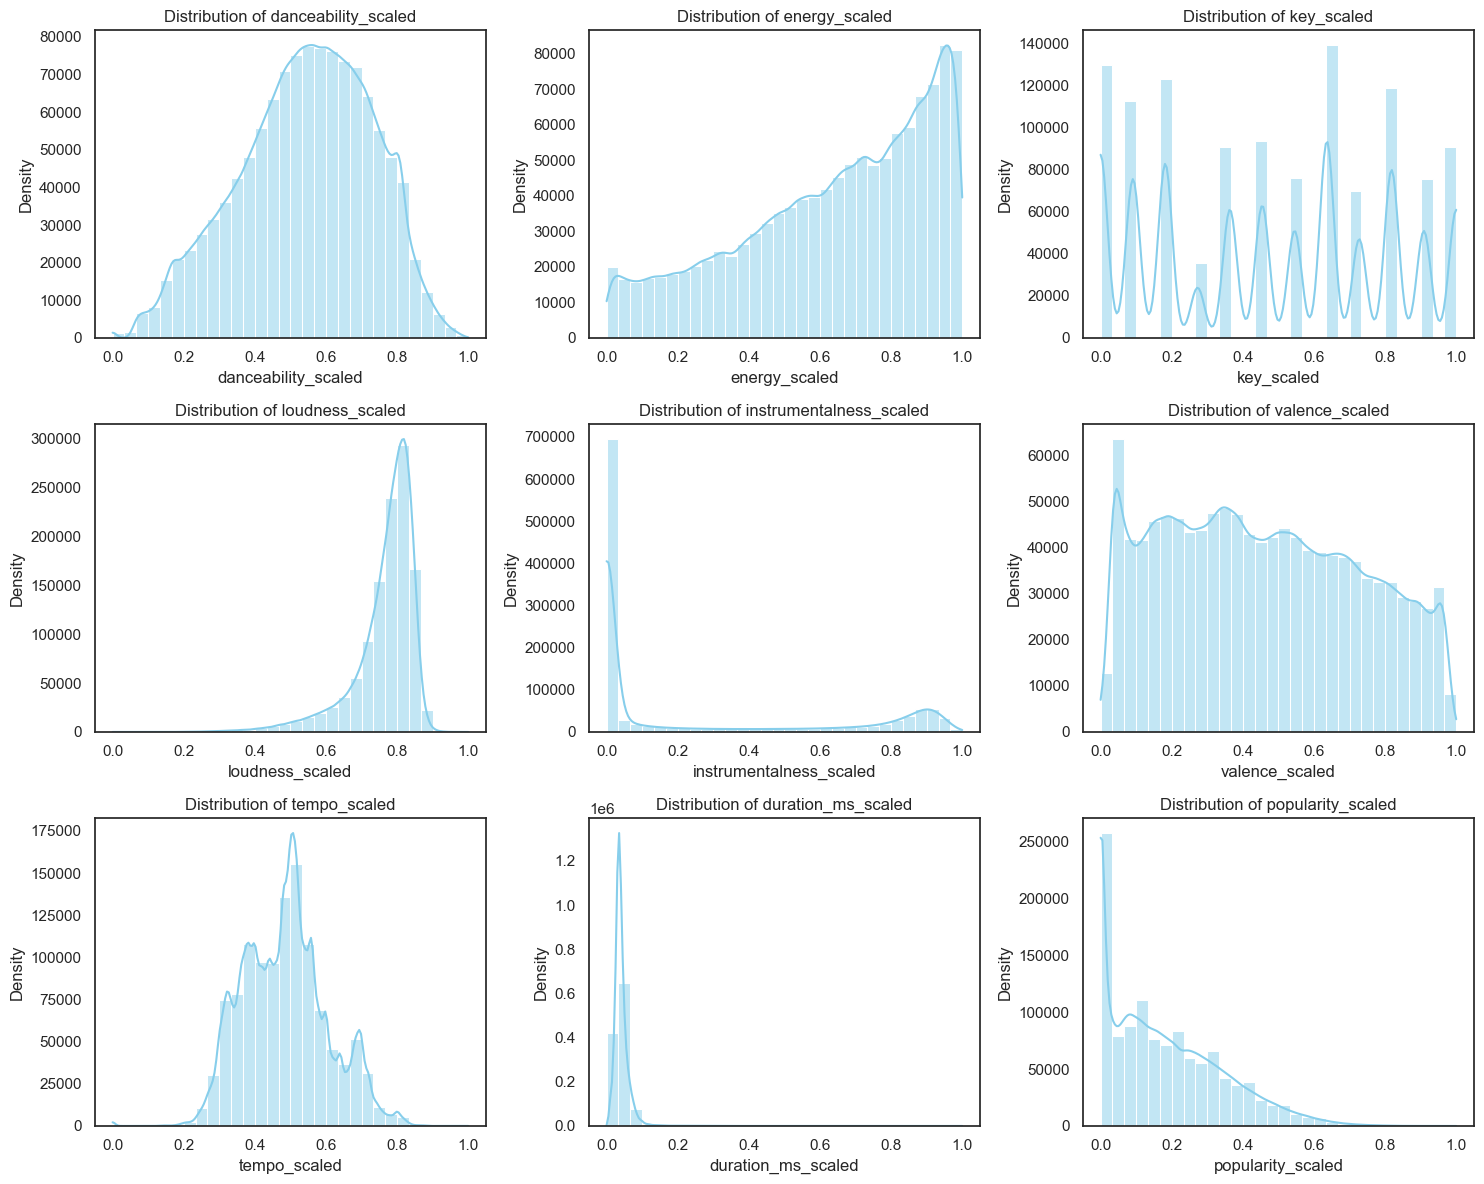

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas for visualization
features_to_plot = [
    'danceability_scaled', 'energy_scaled', 'key_scaled', 
    'loudness_scaled', 'instrumentalness_scaled', 'valence_scaled', 
    'tempo_scaled', 'duration_ms_scaled', 'popularity_scaled'
]
features_pd = spotify_df_final.select(features_to_plot).toPandas()

# Adjust grid size for 9 features (3x3 layout)
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features_to_plot, start=1):
    plt.subplot(3, 3, i)  # Change to 3 rows x 3 columns
    sns.histplot(features_pd[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()


*Noticeable patterns:*

* Features like `danceability` and `energy` have a more balanced distribution.
* `instrumentalness` is highly skewed towards zero, suggesting most songs in the dataset are not instrumental.
* Features like `tempo` and `loudness` show normal or bimodal distributions, indicating variation in the dataset that needs to be considered when building the recommendation model.


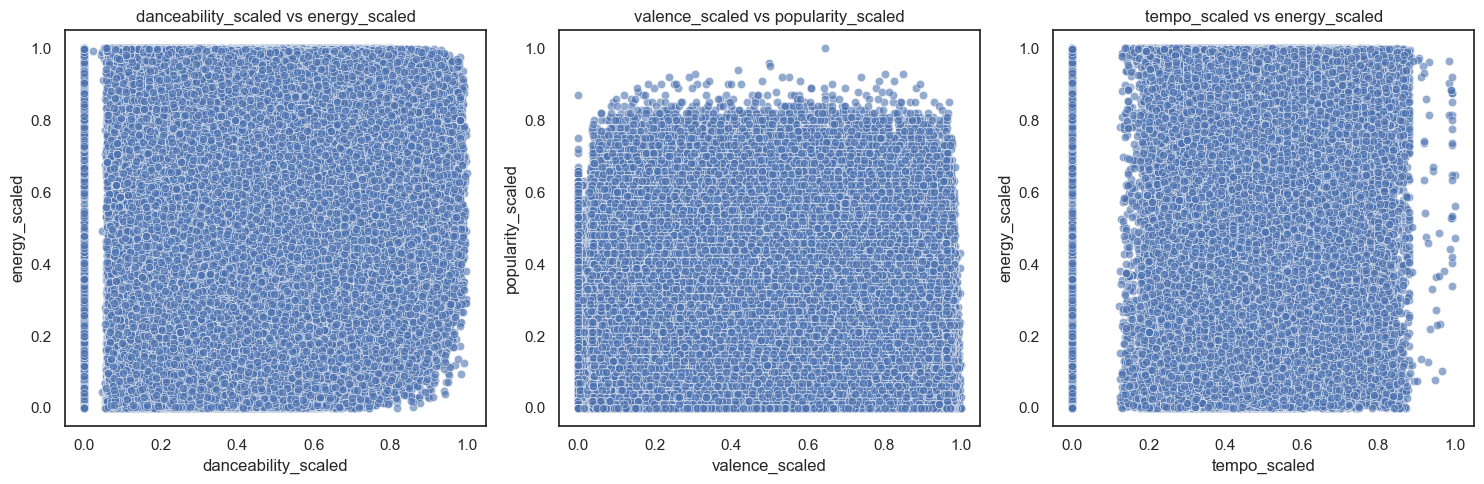

In [34]:
# Pairwise Scatter Plots for selected feature pairs

selected_pairs = [
    ('danceability_scaled', 'energy_scaled'),
    ('valence_scaled', 'popularity_scaled'),
    ('tempo_scaled', 'energy_scaled')
]

# Plot scatter plots
plt.figure(figsize=(15, 5))
for i, (x, y) in enumerate(selected_pairs, start=1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=features_pd[x], y=features_pd[y], alpha=0.6)
    plt.title(f'{x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
plt.tight_layout()
plt.show()


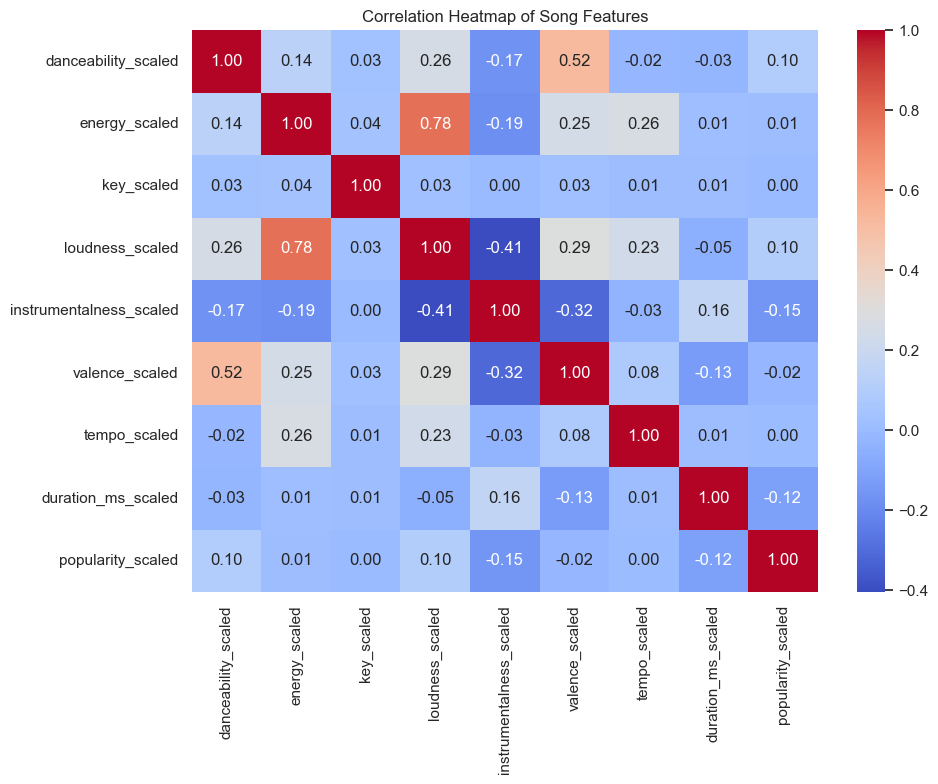

In [35]:
# Correlation Heatmap

# Compute pairwise correlations
correlation_matrix = features_pd.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap of Song Features')
plt.tight_layout()
plt.show()


*Notes:* This heatmap shows correlations between scaled numerical features.

* Strong correlations:
    * `energy` and `loudness` (0.78): Louder songs tend to have higher energy.
    * `valence` and `danceability` (0.52): More positive songs are often more danceable.
* Weak or negligible correlations between most features (e.g., `key` and others), implying independence that can benefit recommendation diversity.

# 7. Model Building and Results

*Updates about fetching `audio_features` from Spotify's Web API:*
Starting from November 27, 2024, Spotify's Web API use cases will "no longer be able to access or use the following endpoints and functionality in their third-party applications" including Audio Features (`audio_features`). It is mentioned on their [official blog](https://developer.spotify.com/blog/2024-11-27-changes-to-the-web-api). 

Therefore, we will switch the strategy to replace comparing audio features-based similarity to:

* Use Genre-Based Similarity.
* Use Artist Similarity.
* Use Popularity and Temporal Trends.

Then, we will combine all these features into a hybrid model. This means, instead of relying on a single feature, we will combine multiple features (e.g., genres, artists, popularity, year) into a composite similarity score. Here's the approach:

* Assign weights to each feature based on its importance.
* Compute a composite similarity score for recommendations:
    * E.g. Similarity = w1 * GenreScore + w2 * ArtistScore + w3 * PopularityScore + w4 * TemporalScore


## 7.1. Model Building

In this section, we will implement 3 main steps:

* Preprocessing for recommendation computation: We will use the Spotify API to extract metadata for the user's playlist (e.g., artist-level genres, release year, and popularity). Then we will create a pipeline to do that automatically.
* 


In [31]:
# Optional: install Spotipy library if needed
# !pip install spotipy

In [32]:
# Set up Spotify API integration

# import libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# use the credentials below for this project
SPOTIFY_CLIENT_ID = "f751f8d37b1649bba54d9afeb690d4fb"
SPOTIFY_CLIENT_SECRET = "d80ffd48133649f5b55e1f76381fd422"

# authenticate with the Spotify API
auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Test the connection
try:
    # Make a test request (e.g., search for a track or fetch a known entity)
    test_response = sp.search(q="test", type="track", limit=1)
    if test_response:
        print("Connection successful! Status: 200")
except Exception as e:
    print(f"Connection failed: {e}")


Connection successful! Status: 200


*Note:*

The user's input playlist is usally a small dataset, for example, about 100 songs in a Top Hits playlist. Spark is usually better suited for large datasets and it incurs setup and partitioning overheads. That's why using Spark for a small dataset takes long time to run and complete compared with using Python's Pandas. 

Benefits of using Pandas instead of Spark for small datasets:
No need to initialize Spark sessions or manage distributed jobs for small datasets.
Direct integration with Python and spotipy eliminates complexity.
For small datasets, pandas processes data faster because it operates in-memory.

Therefore, for User's input playlist, we will choose to use Python's Pandas instead of Spark DataFrame.

In [33]:
# Function to fetch playlist data from Spotify API
def fetch_enriched_playlist_tracks(playlist_url, batch_size=50):
    playlist_id = playlist_url.split("/")[-1]
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
        client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET))
    
    tracks = []
    results = sp.playlist_tracks(playlist_id)

    while results:
        for item in results['items']:
            track = item['track']
            if track and 'id' in track:
                tracks.append({
                    "track_id": track['id'],
                    "track_name": track['name'],
                    "artist_id": track['artists'][0]['id'],
                    "album_name": track['album']['name'],
                    "release_date": track['album']['release_date'],
                    "release_year": track['album']['release_date'][:4],
                    "popularity": track['popularity'],
                    "duration_ms": track['duration_ms']
                })
        results = sp.next(results) if results['next'] else None

    # Get related info of artists
    enriched_data = []
    for i in range(0, len(tracks), batch_size):
        batch = tracks[i:i + batch_size]
        artist_ids = [row['artist_id'] for row in batch]

        try:
            artists_info = sp.artists(artist_ids)['artists']
            for row, artist_info in zip(batch, artists_info):
                enriched_data.append({
                    **row,
                    'artist_name': artist_info.get('name', ''),
                    'artist_genres': artist_info.get('genres', []),
                    'artist_popularity': artist_info.get('popularity', 0)
                })
        except Exception as e:
            print(f"Error processing batch: {e}")

    return enriched_data


In [34]:
# Fetch playlist data
playlist_url = "https://open.spotify.com/playlist/2fmTTbBkXi8pewbUvG3CeZ"

# Get related info of artists
user_playlist_data = fetch_enriched_playlist_tracks(playlist_url, batch_size=50)
user_playlist_df = pd.DataFrame(user_playlist_data)

user_playlist_df.head()

,track_id,track_name,artist_id,album_name,release_date,release_year,popularity,duration_ms,artist_name,artist_genres,artist_popularity
0,0sf12qNH5qcw8qpgymFOqD,Blinding Lights,1Xyo4u8uXC1ZmMpatF05PJ,Blinding Lights,2019-11-29,2019,17,201573,The Weeknd,"[canadian contemporary r&b, canadian pop, pop]",96
1,0nbXyq5TXYPCO7pr3N8S4I,The Box,757aE44tKEUQEqRuT6GnEB,Please Excuse Me for Being Antisocial,2019-12-06,2019,80,196652,Roddy Ricch,"[melodic rap, rap, trap]",80
2,7igeByaBM0MgGsgXtNxDJ7,positions,66CXWjxzNUsdJxJ2JdwvnR,positions,2020-10-23,2020,1,172324,Ariana Grande,[pop],95
3,6UelLqGlWMcVH1E5c4H7lY,Watermelon Sugar,6KImCVD70vtIoJWnq6nGn3,Fine Line,2019-12-13,2019,81,174000,Harry Styles,[pop],85
4,3Dv1eDb0MEgF93GpLXlucZ,Say So,5cj0lLjcoR7YOSnhnX0Po5,Hot Pink,2019-11-07,2019,73,237893,Doja Cat,"[dance pop, pop]",87


In [35]:
# quick check of user's playlist dataframe
user_playlist_df.describe()

,popularity,duration_ms,artist_popularity
count,100.000000,100.000000,100.000000
mean,59.290000,197867.340000,83.330000
std,25.917232,38056.886948,10.342669
min,0.000000,129370.000000,55.000000
25%,59.500000,172600.000000,79.000000
50%,69.500000,195024.500000,84.500000
75%,74.000000,214977.000000,92.000000
max,86.000000,361026.000000,100.000000


In [36]:
# quick check of user's playlist dataframe
user_playlist_df.shape

(100, 11)

*Note:*

The dataframe is properly fetched and formatted. For example:
* Genres (`artist_genres`) are properly listed in a string format (which is expected as a list).
* Artist's metadata such as `artist_popularity` and `track_popularity` are also well retrieved.

### One-hot Encoding vs. TF-IDF Vectorization for comparing genres between User's Playlist and 1M+ dataset

Term frequency-inverse document frequency (TF-IDF) vectorization is a statistical method that converts text documents into vectors of numerical data based on the importance of words in the document.

One-Hot Encoding is the method to create the binary vector for each genre while TF-IDF Vectorization creates weighted vector based on importance of genres. The similarity metric of one-hot encoding is to find exact matches between songs; no concept of "close" matches. However, TF-IDF Vectorization can be used for similarity scores based on vector distance. 

Therefore, we will use TF-IDF Vectorization to compare genres and other features between User's Playlist and 1M+ dataset. We will use Spark's [HashingTF](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.HashingTF.html) for this task.

In [72]:
# Step 1: Create and Apply TF-IDF Pipelines
# Build a single pipeline for TF-IDF computation and apply it to both the user’s playlist and the 1M+ dataset.
# Validate the pipeline outputs on a subset to ensure correctness.
# Step 2: Introduce Performance Optimizations
# Pre-filter the 1M+ dataset based on genre clusters or similar metadata before the cross-join.
# Broadcast the user’s playlist if it is small enough to fit in memory.
# Use built-in Spark vector operations for cosine similarity.
# Step 3: Scale Up Gradually
# Start with a subset of the 1M+ dataset for testing and feedback.
# Once the approach is validated, scale up to the full dataset with all optimizations in place.

In [73]:
# 1. Define the Pipeline
# Create a pipeline with the following stages:
# 
# Tokenizer: Splits the genre strings into tokens.
# HashingTF: Computes term frequency vectors.
# IDF: Computes the TF-IDF representation.

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.functions import col, concat_ws

# set the numFeatures parameter in HashingTF 
# note: if numFeatures is too small (e.g. < 100), it will cause hashing collisions
FEATURES = 1000

## Create the pipeline for User's Playlist

# Define pipeline stages
tokenizer = Tokenizer(inputCol="artist_genres_str", outputCol="genre_tokens")
hashingTF = HashingTF(inputCol="genre_tokens", outputCol="genre_features", numFeatures=FEATURES)
idf = IDF(inputCol="genre_features", outputCol="genre_tfidf")

# Create the pipeline for User's Playlist
playlist_tfidf_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])


## Create the pipeline for 1M+ Spotify dataset

# Define pipeline stages
tokenizer = Tokenizer(inputCol="genre", outputCol="genre_tokens")
hashingTF = HashingTF(inputCol="genre_tokens", outputCol="genre_features", numFeatures=FEATURES)
idf = IDF(inputCol="genre_features", outputCol="genre_tfidf")

# Create the pipeline for 1M+ Spotify dataset
dataset_tfidf_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])


In [74]:
# 2. Apply the Pipeline to the User’s Playlist

# Create Spark DataFrame
user_playlist_spark = spark.createDataFrame(user_playlist_df)
# Ensure the user playlist has the required column (artist_genres_str)
user_playlist_spark = user_playlist_spark.withColumn("artist_genres_str", concat_ws(" ", col("artist_genres")))

# Fit the pipeline on the user playlist
user_pipeline_model = playlist_tfidf_pipeline.fit(user_playlist_spark)
user_playlist_tfidf = user_pipeline_model.transform(user_playlist_spark)

# Show the resulting TF-IDF features for the user playlist
user_playlist_tfidf.select("track_id", "artist_genres_str", "genre_tfidf").show(5)


+--------------------+--------------------+--------------------+
|            track_id|   artist_genres_str|         genre_tfidf|
+--------------------+--------------------+--------------------+
|0sf12qNH5qcw8qpgy...|canadian contempo...|(1000,[452,482,65...|
|0nbXyq5TXYPCO7pr3...|melodic rap rap trap|(1000,[210,491,82...|
|7igeByaBM0MgGsgXt...|                 pop|(1000,[659],[0.31...|
|6UelLqGlWMcVH1E5c...|                 pop|(1000,[659],[0.31...|
|3Dv1eDb0MEgF93GpL...|       dance pop pop|(1000,[251,659],[...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [75]:
user_playlist_tfidf.show(5)

+--------------------+----------------+--------------------+--------------------+------------+------------+----------+-----------+-------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|            track_id|      track_name|           artist_id|          album_name|release_date|release_year|popularity|duration_ms|  artist_name|       artist_genres|artist_popularity|   artist_genres_str|        genre_tokens|      genre_features|         genre_tfidf|
+--------------------+----------------+--------------------+--------------------+------------+------------+----------+-----------+-------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|0sf12qNH5qcw8qpgy...| Blinding Lights|1Xyo4u8uXC1ZmMpat...|     Blinding Lights|  2019-11-29|        2019|        17|     201573|   The Weeknd|[canadian contemp...|               96|canadian cont

In [76]:
# 3. Apply the Pipeline to the 1M+ Spotify Dataset
# Extract genres from the 1M+ dataset
# spotify_genre_df = spotify_df_final.select("track_id", "genre").distinct()

# Fit the pipeline
dataset_pipeline_model = dataset_tfidf_pipeline.fit(spotify_df_final)
spotify_dataset_tfidf = dataset_pipeline_model.transform(spotify_df_final)

# Show the resulting TF-IDF features for the 1M+ dataset
spotify_dataset_tfidf.select("track_id", "genre", "genre_tfidf").show(5)

+--------------------+--------+--------------------+
|            track_id|   genre|         genre_tfidf|
+--------------------+--------+--------------------+
|53QF56cjZA9RTuuMZ...|acoustic|(1000,[968],[4.00...|
|1s8tP3jP4GZcyHDsj...|acoustic|(1000,[968],[4.00...|
|7BRCa8MPiyuvr2VU3...|acoustic|(1000,[968],[4.00...|
|63wsZUhUZLlh1Osyr...|acoustic|(1000,[968],[4.00...|
|6nXIYClvJAfi6ujLi...|acoustic|(1000,[968],[4.00...|
+--------------------+--------+--------------------+
only showing top 5 rows



In [77]:
spotify_dataset_tfidf.show(5)

+----------------+--------------------+--------------------+----+--------+----------------+-------------------+-------------------+------------------+------------------+-----------+-------------------+--------------------+-----------------------+-------------------+--------------+-------------------+--------------------+-----------------+-----------+-----------------+------------------+------------+------------------+--------------------+
|     artist_name|          track_name|            track_id|year|   genre|artist_frequency|danceability_scaled|      energy_scaled|        key_scaled|   loudness_scaled|mode_scaled| speechiness_scaled| acousticness_scaled|instrumentalness_scaled|    liveness_scaled|valence_scaled|       tempo_scaled|  duration_ms_scaled|popularity_scaled|year_period|year_period_index|year_period_onehot|genre_tokens|    genre_features|         genre_tfidf|
+----------------+--------------------+--------------------+----+--------+----------------+-------------------+---

In [78]:
# inspect one certain value of genre_tfidf in User's playlist
first_row = user_playlist_tfidf.select("genre_tfidf").first()
first_genre_tfidf = first_row["genre_tfidf"]
print(first_genre_tfidf)


(1000,[452,482,659,761],[2.6692103677859462,3.9521263744520017,0.6221108472741794,2.312535423847214])


*Note:* The `genre_tfidf` is a sparse vector representation of the TF-IDF values for genres, stored in the `(size, indices, values)` format. 

For example: `(100, [52,59,61,82], [2.05, 0.62, 2.22, 3.95])` value above.

* `100`: The vector size (number of features in the hashing space).
* `[52,59,61,82]`: The indices of the features in the vector that have non-zero values.
* `[2.05, 0.62, 2.22, 3.95]`: The corresponding TF-IDF values for those indices.


**Validation on a Subset:**

The purpose of this validation step is to ensure that the TF-IDF pipeline outputs are consistent for both the user's playlist and the 1M+ dataset.

In [79]:
# TEST
## Step 1: Sample a Subset of the 1M+ Dataset

# Sample 1% of the 1M+ dataset for validation
spotify_subset_tfidf = spotify_dataset_tfidf.sample(fraction=0.01)

# Show the sampled data
spotify_subset_tfidf.select("track_id", "track_name", "genre", "genre_tfidf").show(5)


+--------------------+-------------------+--------+--------------------+
|            track_id|         track_name|   genre|         genre_tfidf|
+--------------------+-------------------+--------+--------------------+
|77xgXc56h19AhTLKr...|    Better with You|acoustic|(1000,[968],[4.00...|
|32SjCGePcnCkvWAbs...|  She Will Be Loved|acoustic|(1000,[968],[4.00...|
|6W7ILdWPWX5zYlsmH...|What If I Am Queer?|acoustic|(1000,[968],[4.00...|
|2FlHJnYeLDWK3kw2X...|      Paris in June|acoustic|(1000,[968],[4.00...|
|5vypcmaP4DnqH71TG...|   Jingle Bell Rock|acoustic|(1000,[968],[4.00...|
+--------------------+-------------------+--------+--------------------+
only showing top 5 rows



In [80]:
# # Step 2: Compare genre_tfidf Between the Playlist and the 1M+ Subset
# Approach:
# Pick a single track from the user's playlist.
# Compare its genre_tfidf vector with the vectors from the 1M+ subset using cosine similarity.
# Validate that similar genres produce higher similarity scores, and dissimilar genres produce lower scores.

from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors, DenseVector
import numpy as np

# Pick a track from the user's playlist for comparison
selected_playlist_track = user_playlist_tfidf.filter(col("track_name") == "Blinding Lights").select("track_id", "genre_tfidf").first()
playlist_vector = Vectors.dense(selected_playlist_track["genre_tfidf"])

# Define a UDF to compute cosine similarity
def cosine_similarity_udf(playlist_vec):
    def compute_similarity(subset_vec):
        dot_product = float(np.dot(playlist_vec, subset_vec))
        norm1 = np.linalg.norm(playlist_vec)
        norm2 = np.linalg.norm(subset_vec)
        return float(dot_product / (norm1 * norm2)) if norm1 > 0 and norm2 > 0 else 0.0
    return compute_similarity

# Register the UDF
cosine_similarity = udf(cosine_similarity_udf(np.array(playlist_vector)), FloatType())

# Add a similarity score column
spotify_subset_tfidf = spotify_subset_tfidf.withColumn(
    "similarity_score",
    cosine_similarity(col("genre_tfidf"))
)

# Show tracks with the highest similarity to the selected playlist track
spotify_subset_tfidf.orderBy(col("similarity_score").desc()).select("track_id", "track_name", "genre", "similarity_score").show(5)


+--------------------+--------------------+---------+----------------+
|            track_id|          track_name|    genre|similarity_score|
+--------------------+--------------------+---------+----------------+
|23Bn6gI00WNWHFNos...|           Zachariah|hard-rock|       0.7405762|
|2NakapiJVH4YULWTS...|Werewolf Women of...|hard-rock|       0.7405762|
|6rCp71jUgFxbGNsBq...| Children of the Sun|hard-rock|       0.7405762|
|2ieVVTWjjCXRhCtQd...|       Allied Forces|hard-rock|       0.7405762|
|2J5aJp4HQxcMuxZ6H...|From The Pinnacle...|hard-rock|       0.7405762|
+--------------------+--------------------+---------+----------------+
only showing top 5 rows



In [81]:
# TEST
spotify_subset_tfidf.filter(col("genre").isin("hard-rock")).select("genre", "genre_tfidf").show()


+---------+--------------------+
|    genre|         genre_tfidf|
+---------+--------------------+
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
|hard-rock|(1000,[482],[4.42...|
+---------+--------------------+
only showing top 20 rows



*Note:* The genres are clustered into groups as expected. For example, the first `genre_cluster` (label `0`) contains various genres like `acoustic` and `afrobeat`, etc.

## Compute similarities for recommendation

There are 3 steps: 

**1. Prepare the Data:**
We will compare the genre_tfidf vectors of the user’s playlist and the 1M+ dataset:
* Ensure both playlist_genre_tfidf (user's playlist) and spotify_genre_tfidf (1M+ dataset) have the same vector representation.
* Each row represents a song with its track_id and genre_tfidf vector.

**2. Use Cross-Join for Pairwise Similarity:**
* A cross-join between the two datasets generates all possible pairs of songs (one from the user’s playlist and one from the 1M+ dataset).
* We then compute cosine similarity for each pair.

**3. Filter and Rank Recommendations**
* Exclude songs that are already in the user’s playlist.
* Rank recommendations by similarity score, and select the top-N most similar songs.

In [82]:
TEST
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import FloatType

# Step 1: Define a cosine similarity function
def cosine_similarity(vec1, vec2):
    if not vec1 or not vec2:
        return 0.0
    dot_product = float(vec1.dot(vec2))
    norm1 = float(vec1.norm(2))
    norm2 = float(vec2.norm(2))
    if norm1 == 0.0 or norm2 == 0.0:
        return 0.0
    return dot_product / (norm1 * norm2)

# Register UDF
cosine_similarity_udf = udf(cosine_similarity, FloatType())

NameError: name 'TEST' is not defined

In [70]:
# Step 2: Cross-Join to Compute Pairwise Similarities
# Rename columns to avoid conflicts in the join
user_tfidf = playlist_genre_tfidf.select(
    col("track_id").alias("user_track_id"),
    col("genre_tfidf").alias("user_genre_tfidf")
)

spotify_tfidf = spotify_genre_tfidf.select(
    col("track_id").alias("spotify_track_id"),
    col("genre_tfidf").alias("spotify_genre_tfidf")
)

# Cross-join the two datasets
cross_joined = user_tfidf.crossJoin(spotify_tfidf)

# Compute Cosine Similarity for Each Pair
similarities = cross_joined.withColumn(
    "similarity_score",
    cosine_similarity_udf(col("user_genre_tfidf"), col("spotify_genre_tfidf"))
)


NameError: name 'playlist_genre_tfidf' is not defined

In [ ]:
# Step 3a: Exclude Songs Already in the Playlist
# Collect user playlist track IDs
user_track_ids = [row["user_track_id"] for row in user_tfidf.select("user_track_id").distinct().collect()]

# Filter out tracks already in the user's playlist
recommendations = similarities.filter(~col("spotify_track_id").isin(user_track_ids))

# Step 3b: Rank Recommendations by Similarity
top_recommendations = recommendations.orderBy(col("similarity_score").desc()).select(
    "spotify_track_id", "similarity_score"
)

# Show top recommendations
top_recommendations.show(10)